## Imports

In [160]:
import random
import pandas as pd
import numpy as mp
import matplotlib.pyplot as plt
import seaborn as sns

import scipy 
from scipy import cluster
from scipy.stats import zscore

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans


from xgboost import XGBRegressor

from interpretableai import iai

from functools import partial

from multiprocessing import Pool, cpu_count

from tqdm.notebook import trange, tqdm

## Global Variables

In [104]:
path_sales= "./SalesProcessedDataSet_v2.csv"
path_ebitda="./EBITDAProcessedDataSet_v2.csv"

df_sales=pd.read_csv(path_sales)
df_ebitda=pd.read_csv(path_ebitda)

split=0.3

## Model Functions
Take input X_train, y_train, X_test, y_test

Return model, prediction

In [105]:
def iai_oct(X_train,y_train,X_test,y_test):
    '''
    General function that runs OCT and outputs the predictions
    '''  
    try:
        grid = iai.GridSearch(iai.OptimalTreeRegressor(random_seed=1,criterion='mse'),max_depth=range(7, 12),minbucket=[20,40,50,60,100])
        grid.fit(X_train, y_train)
        grid.get_learner()
    except:
        grid = iai.GridSearch(iai.OptimalTreeRegressor(random_seed=1,criterion='mse'),max_depth=range(7, 12))
        grid.fit(X_train, y_train)
        grid.get_learner()
    y_pred=grid.predict(X_test)
    return grid.get_learner(), y_pred

def xgbReg(X_train, y_train, X_test,y_test):
    '''
    General function that runs XGB and outputs the predictions
    '''   
    xgb = GridSearchCV(XGBRegressor(n_jobs=1),
                   {'max_depth': [2, 3, 4, 5,6],
                    'n_estimators': [80, 100,150, 200],
                   'learning_rate':[0.05,0.15,0.3]}, verbose=1, n_jobs=-1)
    
    xgb = xgb.fit(X_train, y_train)

    y_pred = xgb.predict(X_test)
    
    return xgb.best_estimator_, y_pred

def linReg(X_train, y_train, X_test,y_test):
    '''
    General function that runs Linear Regression and outputs the predictions, r2, and error
    '''
    lr = GridSearchCV(linear_model.Lasso(tol = 0.01, max_iter = 50000),
                     {'alpha': [0.1, 0.25, 0.5, 0.75, 1]})
    lr = lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)    
    return lr.best_estimator_, y_pred

def cartReg(X_train, y_train, X_test,y_test):
    
    '''
    General function that runs CART and outputs the predictions, r2, and error
    '''
    cart = GridSearchCV(tree.DecisionTreeRegressor(),
                   {'max_depth': [2,3,4,5,6]})
    
    cart = cart.fit(X_train, y_train)

    y_pred = cart.predict(X_test)    
    return cart.best_estimator_, y_pred
    
def rfReg(X_train, y_train, X_test,y_test):
    '''
    General function that runs Random Forest and outputs the predictions, r2, and error
    '''
    rf_y_train = y_train.values.ravel()
    
    rf = GridSearchCV(RandomForestRegressor(random_state=1,n_jobs=-1),
                   {'max_depth': [2,3,4, 5,6],
                    'n_estimators': [80,100,150,200]}, verbose=1, n_jobs=1)
    
    rf = rf.fit(X_train, rf_y_train)

    y_pred = rf.predict(X_test)
    return rf.best_estimator_, y_pred
    
def train_model(X_train,y_train,X_test,y_test, model_func):
    """
    Training wrapper for a given model function
    return trained model
    """
    return model_func(X_train,y_train,X_test,y_test)

def evaluate_perf(model,y_test,pred):
    """
    Evaluate model performance
    return dict containing model name, model, perf metrics
    """
    r2=r2_score(y_test, pred, multioutput='variance_weighted')
    mae=mean_absolute_error(y_test,pred)
    model_name=type(model).__name__
    return {"model_name":model_name,"model":model,"OSR2":r2,"MAE":mae}

def train_eval_model(X_train,y_train,X_test,y_test, model_func):
    """
    Train and eval model
    return dict containing model name, model, perf metrics
    """
    model,pred=train_model(X_train,y_train,X_test,y_test, model_func)
    return evaluate_perf(model,y_test,pred)

## Pipeline Functions

In [106]:
def build_dataset(df,x_col,y_label,test_size,random_state=42):
    """
    Build dataset from given df, list of col for X and label of y and train/test split size
    return X_train, X_test, y_train, y_test
    """
    X=df[x_col].fillna(0)
    y=df[y_label]
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def seq_models(df,x_col,y_label,model_list,test_size,random_state=42):
    """
    Train and evaluate models sequentially
    Returns dataframe with results as well as train and test sets
    """
    X_train, X_test, y_train, y_test = build_dataset(df,x_col,y_label,test_size,random_state)
    train_eval_wrapper=partial(train_eval_model,X_train,y_train,X_test,y_test)
    result=[]
    for model in tqdm(model_list):
        result.append(train_eval_wrapper(model))
    return pd.DataFrame(result), X_train, X_test, y_train, y_test
        

## Execution

In [107]:
x_col=['Region_APAC', 'Region_EU', 'Region_MEA', 'Region_NAM', 'Sector_Banks',
       'Sector_Chemicals, rubber, plastics, non-metallic products',
       'Sector_Construction', 'Sector_Education, Health',
       'Sector_Food, beverages, tobacco', 'Sector_Gas, Water, Electricity',
       'Sector_Hotels & restaurants', 'Sector_Insurance companies',
       'Sector_Machinery, equipment, furniture, recycling',
       'Sector_Metals & metal products', 'Sector_Other services',
       'Sector_Post and telecommunications',
       'Sector_Primary Sector (agriculture, mining, etc.)',
       'Sector_Public administration and defence',
       'Sector_Publishing, printing',
       'Sector_Textiles, wearing apparel, leather', 'Sector_Transport',
       'Sector_Wholesale & retail trade', 'Sector_Wood, cork, paper',
       'DealType_IPO', 'DealType_Minority stake', 'CompletedDate', 'Stake',
       'PreRevMult', 'PreEBITDAMult', 'PostRevMult', 'PostEBITDAMult',
       'PreRev', 'PreEBITDA', 'PostRev', 'PostEBITDA', 'LastRev',
       'LastRevPrev1', 'LastRevPrev2', 'LastEBITDA', 'LastEBITDAPrev1',
       'LastEBITDAPrev2', 'ValuationP0_S', 'ValuationP1_S', 'ValuationP2_S',
       'ValuationPreInvestment_S', 'ValuationAtInvestment_S','MarginEBITDAPrev1', 'MarginEBITDAPrev2',
       'PostMarginEBITDA']

y_labels=['ROIY1_S','ROIY2_S','ROIY3_S']

model_list=[rfReg,cartReg,linReg,iai_oct,xgbReg]

all_results={}

for y_label in tqdm(y_labels):
    print("Computing: {}".format(y_label))
    results, X_train, X_test, y_train, y_test=seq_models(df_sales,x_col,y_label,model_list,split)
    all_results[y_label]=results

Computing: ROIY1_S


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   53.6s finished
/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 653.1247906695374, tolerance: 17.248567715556725
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 675.6218338133922, tolerance: 17.69369804070144
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 598.6479812302427, tolerance: 15.218480955646898
  model = c

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.2min finished



Computing: ROIY2_S


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   51.1s finished
/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 784.9163061437895, tolerance: 20.591657769772628
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 807.7128755178583, tolerance: 20.997660780452925
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 723.0885786329503, tolerance: 18.312761031140504
  model = 

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.1min finished



Computing: ROIY3_S


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   48.9s finished
/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1550.8810745694257, tolerance: 36.959995582937026
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1612.7395269092483, tolerance: 37.797521129808985
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1509.701555508019, tolerance: 34.42765859027908
  model =

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.6min finished


In [108]:
all_results["ROIY1_S"]

,model_name,model,OSR2,MAE
0,RandomForestRegressor,"(DecisionTreeRegressor(max_depth=6, max_featur...",0.449307,0.551640
1,DecisionTreeRegressor,DecisionTreeRegressor(max_depth=4),0.049947,0.696433
2,Lasso,"Lasso(alpha=0.1, max_iter=50000, tol=0.01)",0.214197,0.656807
3,OptimalTreeRegressor,Fitted OptimalTreeRegressor:\n 1) Split: PreR...,0.361328,0.563432
4,XGBRegressor,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.589537,0.405734


In [109]:
all_results["ROIY2_S"]

,model_name,model,OSR2,MAE
0,RandomForestRegressor,"(DecisionTreeRegressor(max_depth=6, max_featur...",0.430728,0.615387
1,DecisionTreeRegressor,DecisionTreeRegressor(max_depth=6),0.220547,0.708105
2,Lasso,"Lasso(alpha=0.1, max_iter=50000, tol=0.01)",0.209932,0.729809
3,OptimalTreeRegressor,Fitted OptimalTreeRegressor:\n 1) Split: Post...,0.284270,0.666311
4,XGBRegressor,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.517277,0.492820


In [110]:
all_results["ROIY3_S"]

,model_name,model,OSR2,MAE
0,RandomForestRegressor,"(DecisionTreeRegressor(max_depth=6, max_featur...",0.356079,0.988668
1,DecisionTreeRegressor,DecisionTreeRegressor(max_depth=5),0.268848,1.058280
2,Lasso,"Lasso(alpha=0.1, max_iter=50000, tol=0.01)",0.146199,1.163463
3,OptimalTreeRegressor,Fitted OptimalTreeRegressor:\n 1) Split: Post...,0.182374,1.115830
4,XGBRegressor,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.457732,0.846294


In [289]:
def generate_col(all_results,i):
    suffix="_"+all_results["ROIY1_S"]["model_name"].loc[i]
    
    sales_test_arr_pred=pd.DataFrame({
    "ARR1"+suffix:all_results["ROIY1_S"]["model"].loc[i].predict(X_test)-1,
    "ARR2"+suffix:all_results["ROIY2_S"]["model"].loc[i].predict(X_test)**(1/2)-1,
    "ARR3"+suffix:all_results["ROIY3_S"]["model"].loc[i].predict(X_test)**(1/3)-1   
    }).set_index(y_test.index)




    sales_test_arr_pred["ARR_mean"+suffix]=sales_test_arr_pred[["ARR1"+suffix,"ARR2"+suffix,"ARR3"+suffix]].mean(axis=1)
    sales_test_arr_pred["ARR_std"+suffix]=sales_test_arr_pred[["ARR1"+suffix,"ARR2"+suffix,"ARR3"+suffix]].std(axis=1)

    kmeans = KMeans(n_clusters=10, random_state=0).fit(sales_test_arr_pred[["ARR_mean"+suffix,"ARR_std"+suffix]])

    sales_test_arr_pred["cluster"]=kmeans.labels_
    sales_test_arr_pred[["ARR_mean_cluster"+suffix,"ARR_std_cluster"+suffix]]=sales_test_arr_pred["cluster"]\
        .apply(lambda x:sales_test_arr_pred.groupby("cluster")[["ARR_mean"+suffix,"ARR_std"+suffix]].mean().loc[x])
    return sales_test_arr_pred[["ARR_mean_cluster"+suffix,"ARR_std_cluster"+suffix]]

pred_df=pd.concat([generate_col(all_results,i) for i in range(5)],axis=1)

sales_test_arr=pd.DataFrame({
"ARR1":df_sales.loc[y_test.index]["ROIY1_S"]-1,
"ARR2":df_sales.loc[y_test.index]["ROIY2_S"]**(1/2)-1,
"ARR3":df_sales.loc[y_test.index]["ROIY3_S"]**(1/3)-1
})



sales_test_arr_pred["ARR_mean"]=sales_test_arr_pred[["ARR1","ARR2","ARR3"]].mean(axis=1)
sales_test_arr_pred["ARR_std"]=sales_test_arr_pred[["ARR1","ARR2","ARR3"]].std(axis=1)

kmeans = KMeans(n_clusters=15, random_state=0).fit(sales_test_arr_pred[["ARR_mean","ARR_std"]])

sales_test_arr_pred["cluster"]=kmeans.labels_
sales_test_arr_pred[["ARR_mean_cluster","ARR_std_cluster"]]=sales_test_arr_pred["cluster"]\
    .apply(lambda x:sales_test_arr_pred.groupby("cluster")[["ARR_mean","ARR_std"]].mean().loc[x])

result_export=pd.DataFrame({
"ROIY3":df_sales.loc[y_test.index]["ROIY3_S"],
"mean_arr":sales_test_arr.mean(axis=1),
"std_arr":sales_test_arr.std(axis=1),
#"ARR_mean_cluster":sales_test_arr_pred.mean(axis=1),
#"ARR_std_cluster":sales_test_arr_pred.std(axis=1),
"valuation0":df_sales.loc[y_test.index]["ValuationAtInvestment_S"],  
})

result_export[[col for col in X_test if col.startswith('Region')]]=\
    X_test[[col for col in X_test if col.startswith('Region')]]

result_export[[col for col in X_test if col.startswith('Sector')]]=\
    X_test[[col for col in X_test if col.startswith('Sector')]]

result_export[pred_df.columns]=pred_df

result_export.to_csv("opti_set_k15.csv")


<ipython-input-289-3ccceec7ddcc>:6: RuntimeWarning: invalid value encountered in sqrt
  "ARR2"+suffix:all_results["ROIY2_S"]["model"].loc[i].predict(X_test)**(1/2)-1,


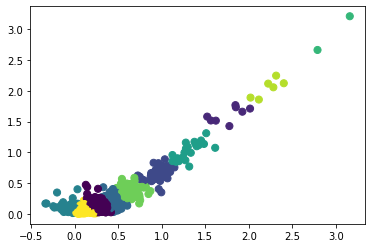

In [246]:
plt.scatter(sales_test_arr_pred["ARR_mean"],\
            sales_test_arr_pred["ARR_std"],\
            c=kmeans.labels_, s=50, cmap='viridis')
#pd.Series(kmeans.labels_).value_counts()

In [281]:
result_export.columns


Index(['ROIY3', 'mean_arr', 'std_arr', 'valuation0', 'Region_APAC',
       'Region_EU', 'Region_MEA', 'Region_NAM', 'Sector_Banks',
       'Sector_Chemicals, rubber, plastics, non-metallic products',
       'Sector_Construction', 'Sector_Education, Health',
       'Sector_Food, beverages, tobacco', 'Sector_Gas, Water, Electricity',
       'Sector_Hotels & restaurants', 'Sector_Insurance companies',
       'Sector_Machinery, equipment, furniture, recycling',
       'Sector_Metals & metal products', 'Sector_Other services',
       'Sector_Post and telecommunications',
       'Sector_Primary Sector (agriculture, mining, etc.)',
       'Sector_Public administration and defence',
       'Sector_Publishing, printing',
       'Sector_Textiles, wearing apparel, leather', 'Sector_Transport',
       'Sector_Wholesale & retail trade', 'Sector_Wood, cork, paper',
       'ARR_mean_cluster_RandomForestRegressor',
       'ARR_std_cluster_RandomForestRegressor',
       'ARR_mean_cluster_DecisionTreeRe

In [278]:
result_export.columns

Index(['ROIY3', 'mean_arr', 'std_arr', 'ARR_mean_cluster', 'ARR_std_cluster',
       'valuation0', 'Region_APAC', 'Region_EU', 'Region_MEA', 'Region_NAM',
       'Sector_Banks',
       'Sector_Chemicals, rubber, plastics, non-metallic products',
       'Sector_Construction', 'Sector_Education, Health',
       'Sector_Food, beverages, tobacco', 'Sector_Gas, Water, Electricity',
       'Sector_Hotels & restaurants', 'Sector_Insurance companies',
       'Sector_Machinery, equipment, furniture, recycling',
       'Sector_Metals & metal products', 'Sector_Other services',
       'Sector_Post and telecommunications',
       'Sector_Primary Sector (agriculture, mining, etc.)',
       'Sector_Public administration and defence',
       'Sector_Publishing, printing',
       'Sector_Textiles, wearing apparel, leather', 'Sector_Transport',
       'Sector_Wholesale & retail trade', 'Sector_Wood, cork, paper',
       'ARR_mean_cluster_RandomForestRegressor',
       'ARR_std_cluster_RandomForestRegre

(6, 49)

,Region_APAC,Region_EU,Region_MEA,Region_NAM,Sector_Banks,"Sector_Chemicals, rubber, plastics, non-metallic products",Sector_Construction,"Sector_Education, Health","Sector_Food, beverages, tobacco","Sector_Gas, Water, Electricity",...,ValuationP2_S,ValuationPreInvestment_S,ValuationAtInvestment_S,ROIY1_S,ROIY2_S,ROIY3_S,MarginEBITDAPrev1,MarginEBITDAPrev2,PostMarginEBITDA,TicketSize
0,0,0,0,1,0,1,0,0,0,0,...,2.849426e+10,2.971548e+10,2.973537e+10,1.228602,1.287353,1.345691,0.318971,0.322093,0.342941,1.680048e+09
1,0,0,0,1,0,0,0,0,0,0,...,7.540034e+09,6.960458e+09,6.953755e+09,1.440220,1.497099,1.535447,0.156337,0.151761,0.141129,1.154323e+09
2,0,0,0,1,0,0,0,0,0,0,...,1.227425e+10,1.167405e+10,1.169353e+10,1.066627,1.118116,1.166778,0.252800,0.276147,0.276147,8.863699e+08
3,0,1,0,0,0,0,0,0,0,0,...,2.336368e+09,2.839406e+09,2.844880e+09,1.190349,1.164862,1.243799,0.584384,0.568216,0.644696,7.915877e+08
4,0,0,0,1,0,1,0,0,0,0,...,1.381672e+10,1.547546e+10,1.548323e+10,1.291868,1.360168,1.369694,0.374214,0.363790,0.386440,7.896449e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1956,0,1,0,0,0,0,0,0,0,0,...,7.363818e+06,7.231518e+06,7.238560e+06,1.744899,1.922950,2.136611,0.149159,0.219787,0.149180,3.962388e+05
1957,1,0,0,0,0,0,0,0,0,0,...,7.356399e+06,6.561042e+06,6.638752e+06,1.132889,1.168689,3.709601,0.241127,0.217811,0.217813,3.943419e+05
1958,0,1,0,0,0,1,0,0,0,0,...,8.294712e+06,7.254852e+06,7.259124e+06,2.651785,2.760582,2.674827,0.107309,0.141645,0.163586,3.901779e+05
1959,0,0,0,1,0,0,0,1,0,0,...,5.676788e+06,6.795360e+06,6.710564e+06,1.164941,1.239242,1.291562,0.016971,0.015595,0.015597,3.825021e+05


In [284]:
import pickle

pickle.dump(all_results,open("models.pickle",'wb'))

TypeError: cannot pickle 'PyCall.jlwrap' object

In [294]:
all_results["ROIY3_S"][["model_name","OSR2","MAE"]].to_csv("pred_res_ROIY3.csv")